In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score,recall_score

In [37]:
# Download the dataset
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [48]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

## **Normalize the data to [0,1]**

In [77]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [78]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

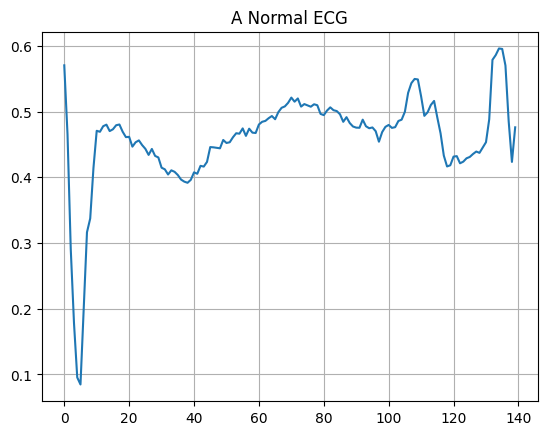

In [79]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

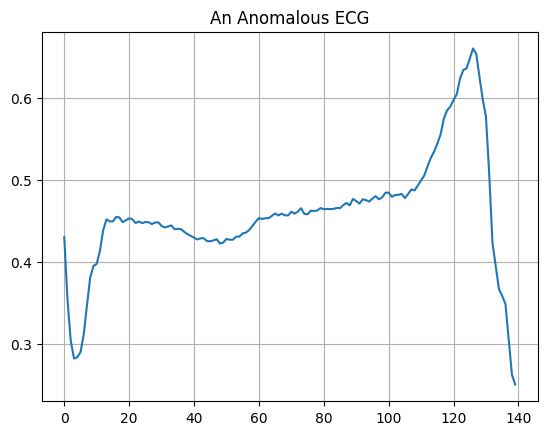

In [80]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [81]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [82]:
autoencoder.compile(optimizer='adam', loss='mae')

In [83]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=256,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0584 - val_loss: 0.0520
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0537 - val_loss: 0.0488
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0467 - val_loss: 0.0452
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0391 - val_loss: 0.0418
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0324 - val_loss: 0.0392
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0285 - val_loss: 0.0378
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0260 - val_loss: 0.0368
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - val_loss: 0.0353
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0342
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0336
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210 - val_loss: 0.0338
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0207 - val_l

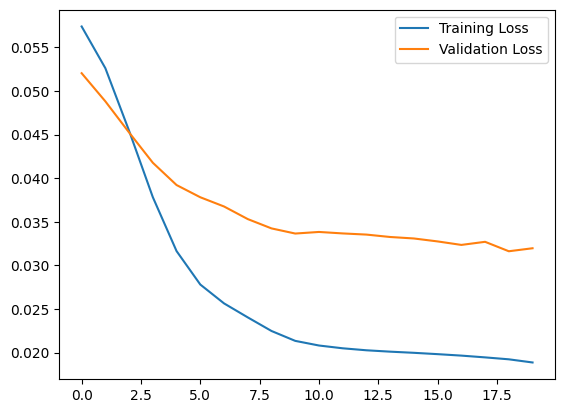

In [84]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

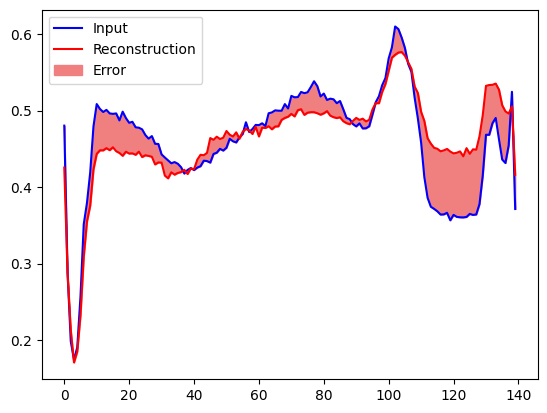

In [85]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Anomulas data

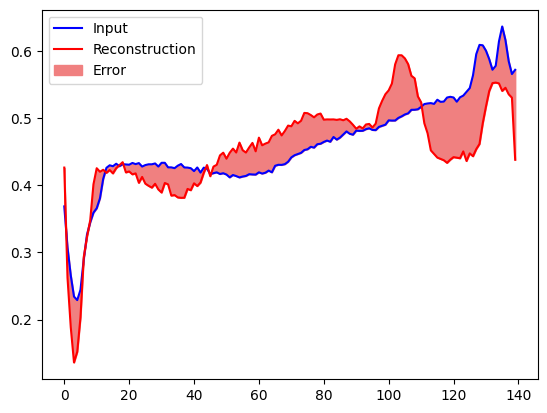

In [86]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Plot the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


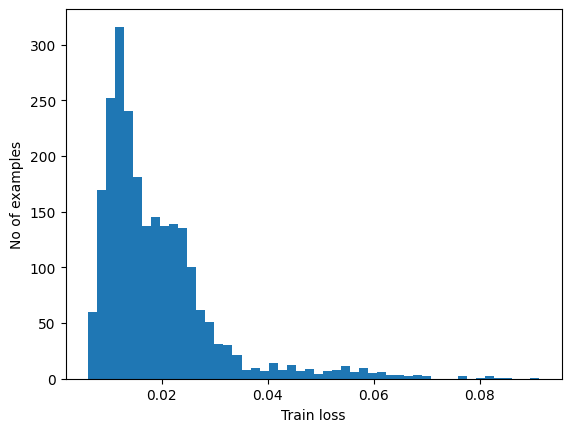

In [87]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [88]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.029961998


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


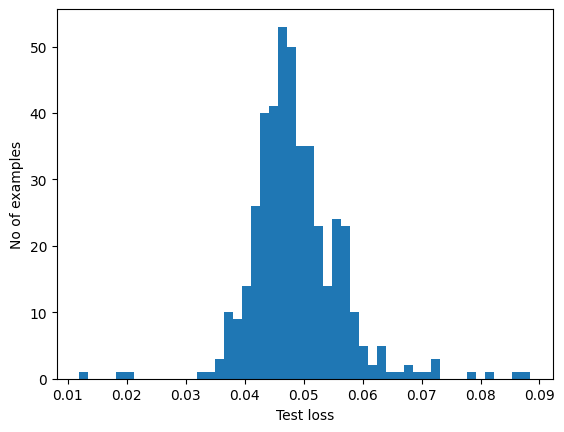

In [89]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [98]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [101]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9941176470588236
Recall = 0.9053571428571429
